In [ ]:
%matplotlib inline

In [1]:
import MDAnalysis as mda
import ARPDF, utils, search_boxes, ARPDF_POLAR
import importlib
import matplotlib.pyplot as plt
import torch
from optimize_ARPDF import ARPDFOptimizer
import pandas as pd


importlib.reload(search_boxes)
importlib.reload(ARPDF)
importlib.reload(utils)
from ARPDF import *
from utils import *
from ARPDF_POLAR import *
from search_boxes import workflow_demo, polar_workflow_demo

/opt/mamba/envs/arpdf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/mamba/envs/arpdf/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
u1, u2, modified_atoms, polar_axis = load_structure_data('data/CCl4')
X, Y = generate_grids(10, N=512)
R, phi = generate_grids_polar((0,10),(0,0.5*np.pi),256,100)
filter_fourier = lambda kX, kY, xp: xp.ones_like(kX)
#filter_fourier = lambda kX, kY, xp: (1 - xp.exp(-(kX**2 / 0.3 + kY**2 / 0.1)))**3 * xp.exp(-0.08 * (kX**2 + kY**2))
# filter_fourier = lambda kX, kY, xp: xp.ones_like(kX)
print(modified_atoms)
sigma0 = 0.2
neg = False
print(f"sigma0 = {sigma0}")

[515, 516, 517, 518, 519, 645]
sigma0 = 0.2


In [ ]:
ARPDF_ref_1 = compute_ARPDF(u1, u2, N=512, cutoff=13.0, sigma0=0.2, grids_XY=(X, Y), modified_atoms=modified_atoms, 
                        polar_axis=polar_axis, periodic=True, filter_fourier=filter_fourier, verbose=True, neg=False)

In [ ]:
ARPDF_trans, R, phi = cartesian_to_polar(ARPDF_ref_1, r_max=10, grid_shape=(360, 128))

In [ ]:
ARPDF_ref_2, X, Y = polar_to_cartesian(ARPDF_trans, r_max=10, grid_shape=(256, 256))

In [ ]:
plt.figure(figsize=(6, 5))
plt.imshow(ARPDF_trans, aspect='auto', cmap='bwr', origin='lower',
           extent=[0, R.max(), 0, 90])  # 横轴是r，纵轴是phi角度（度数）

plt.colorbar(label='Intensity')
plt.xlabel('r (Å)')
plt.ylabel('φ (degree)')
plt.title('ARPDF in Polar Coordinates (f(r, φ))')
plt.tight_layout()
plt.show()

In [ ]:
ARPDF_ref_1.shape

Cannot use cupy, using numpy instead.
Selected 177 atoms in u1, 186 atoms in u2.
Computing polar fields for universe 1...
Computed polar field for C-C: 32 atom pairs.
Computed polar field for C-CL: 230 atom pairs.
Computed polar field for CL-CL: 295 atom pairs.
Computing polar fields for universe 2...
Computed polar field for C-C: 34 atom pairs.
Computed polar field for C-CL: 224 atom pairs.
Computed polar field for CL-CL: 300 atom pairs.


/share/ARPDF/utils/utils.py:387: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


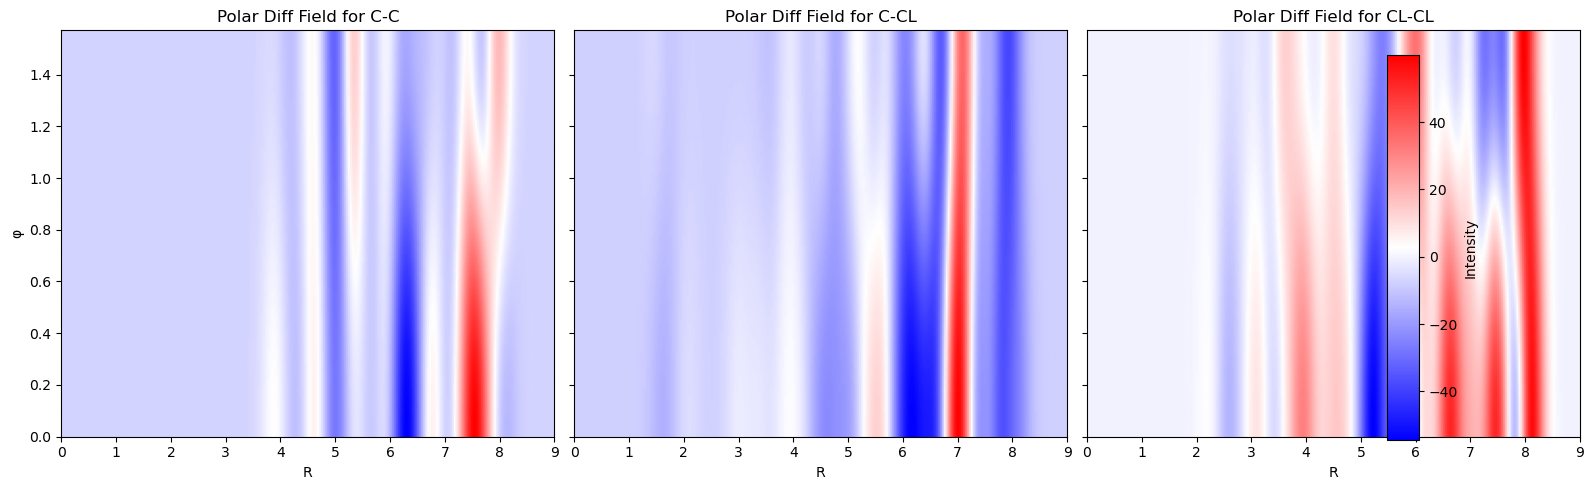

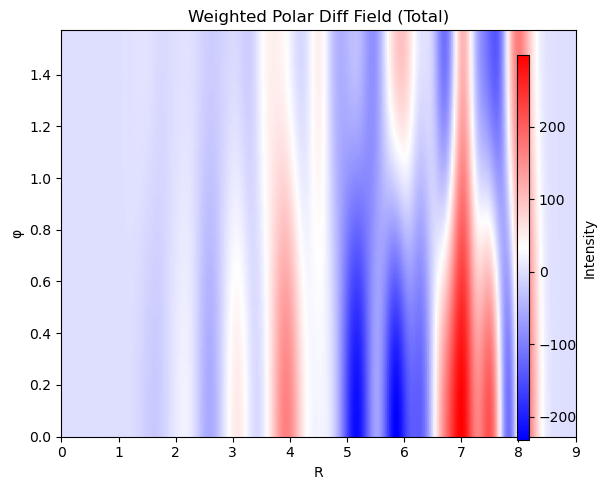

In [3]:
ARPDF_ref,_ = compute_ARPDF_polar(u1, u2, N=512, cutoff=9.0, sigma0=0.2, grids_polar=(R, phi), modified_atoms=modified_atoms, 
                        polar_axis=polar_axis, periodic=True, verbose=True, neg=False)

In [6]:
ARPDF_ref

array([[1.3070061e-15, 1.3087682e-15, 1.3140516e-15, ..., 8.2979252e-15,
        8.3032090e-15, 8.3049700e-15],
       [6.3723610e-15, 6.3811396e-15, 6.4074650e-15, ..., 4.1206012e-14,
        4.1232331e-14, 4.1241109e-14],
       [2.9840327e-14, 2.9882455e-14, 3.0008785e-14, ..., 1.9699337e-13,
        1.9711969e-13, 1.9716180e-13],
       ...,
       [3.5986912e-03, 3.5979743e-03, 3.5958216e-03, ..., 7.5132237e-04,
        7.4917055e-04, 7.4845256e-04],
       [1.4118471e-03, 1.4115639e-03, 1.4107144e-03, ..., 2.8773671e-04,
        2.8688714e-04, 2.8660381e-04],
       [5.3334521e-04, 5.3323759e-04, 5.3291477e-04, ..., 1.0616063e-04,
        1.0583784e-04, 1.0573015e-04]], dtype=float32)

In [ ]:
# 原始数据
f_q1 = ARPDF_ref['total'].T  # shape = (90, 128)

# 镜像得到 90–180°
f_q2 = np.flip(f_q1, axis=0)
# 镜像得到 180–270°
f_q3 = f_q1
# 镜像得到 270–360°
f_q4 = np.flip(f_q1, axis=0)

# 拼接在一起
f_full = np.concatenate([f_q1, f_q2, f_q3, f_q4], axis=0)  # shape = (360, 128)

# 再转换
f_xy, X, Y = polar_to_cartesian(f_full, r_max=10, grid_shape=(256, 256))

# 画图
plt.imshow(f_xy.T, extent=[-10, 10, -10, 10], origin='lower', cmap='bwr')
plt.clim(-40,40)
plt.colorbar()
plt.title('ARPDF (symmetry-extended)')
plt.xlabel('X (Å)')
plt.ylabel('Y (Å)')
plt.xlim(-8,8)
plt.ylim(-8,8)
#plt.axis('equal')
plt.show()


In [ ]:
f_xy.shape

In [ ]:
from utils import generate_grids  # 或者你项目中已有的 generate_grids
import numpy as np

# 假设 cutoff 是你计算 ARPDF 时用的最大半径
cutoff = 10.0
N = 256

X1, Y1 = generate_grids(xy_range=10, N=N)
R1 = np.sqrt(X1**2 + Y1**2)

In [ ]:
from utils.similarity import get_angular_filters  # 用你自己的路径
r0_values = np.linspace(0.5, 8.0, 64)  # 64 个半径点
sigma = 0.1 

angular_filters = get_angular_filters(R1, r0=r0_values, sigma=sigma)

In [ ]:
from utils.similarity import angular_similarity

similarity = angular_similarity(ARPDF_ref_1, f_xy.T, angular_filters)
print(f"Angular similarity = {similarity:.4f}")

In [ ]:
59.2150/64

In [ ]:
# 原图数据是 f_xy，shape = (512, 512)，你做了转置
# 所以 X=0 对应的是 f_xy 的中间行，而非列

x0_index = f_xy.shape[0] // 2  # 中间行索引
cut = f_xy[x0_index, :]        # 沿 Y 轴方向提取

# 生成对应的 Y 坐标
y_vals = np.linspace(-10, 10, f_xy.shape[1])

# 画出切片
import matplotlib.pyplot as plt
plt.plot(y_vals, cut, color='blue')
plt.xlabel('Y (Å)')
plt.ylabel('ARPDF at X = 0')
plt.title('Vertical Slice (X = 0) of ARPDF')
plt.grid(True)
plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')
plt.show()



In [ ]:
X_exp, Y_exp, ARPDF_exp = utils.load_exp_data('data/CCl4', rmax=10.0)

In [ ]:
def compare_slices_x_positive_y0(X_ref, Y_ref, ARPDF_ref,
                                  X_exp, Y_exp, ARPDF_exp,
                                  labels=("Sim", "Exp")):
    """
    Compare ARPDF slices at y=0 and x>0 from two datasets (ref and exp).
    """
    def _to_cpu(arr):
        return arr.get() if hasattr(arr, "get") else arr

    # 保证都在 CPU 上
    X_ref, Y_ref, A_ref = map(_to_cpu, (X_ref, Y_ref, ARPDF_ref))
    X_exp, Y_exp, A_exp = map(_to_cpu, (X_exp, Y_exp, ARPDF_exp))

    # 找出 y=0 最近的一行（横向切片）
    idx_y_ref = np.argmin(np.abs(Y_ref[:, 0]))  # y 是每一行值相同
    idx_y_exp = np.argmin(np.abs(Y_exp[:, 0]))

    # 获取 x>0 部分的切片
    x_ref = X_ref[idx_y_ref, :]
    slice_ref = A_ref[idx_y_ref, :]
    mask_ref = x_ref > 0
    x_ref = x_ref[mask_ref]
    slice_ref = slice_ref[mask_ref]

    x_exp = X_exp[idx_y_exp, :]
    slice_exp = A_exp[idx_y_exp, :]
    mask_exp = x_exp > 0
    x_exp = x_exp[mask_exp]
    slice_exp = slice_exp[mask_exp]

    # 画图
    plt.figure(figsize=(6, 4))
    plt.plot(x_ref, slice_ref*5.8, label=labels[0], lw=2)
    plt.plot(x_exp, slice_exp, label=labels[1], lw=2, linestyle="--")
    plt.xlabel("x (Å)")
    plt.ylabel("ARPDF at y = 0")
    plt.title("Comparison of ARPDF slices (y=0, x>0)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
compare_slices_x_positive_y0(X, Y, ARPDF_ref, X_exp, Y_exp, ARPDF_exp)


In [ ]:
def compare_slices_y_positive_x0(X_ref, Y_ref, ARPDF_ref,
                                  X_exp, Y_exp, ARPDF_exp,
                                  labels=("Sim", "Exp")):
    """
    Compare ARPDF slices at x=0 and y>0 from two datasets (ref and exp).
    """
    def _to_cpu(arr):
        return arr.get() if hasattr(arr, "get") else arr

    # 保证都在 CPU 上
    X_ref, Y_ref, A_ref = map(_to_cpu, (X_ref, Y_ref, ARPDF_ref))
    X_exp, Y_exp, A_exp = map(_to_cpu, (X_exp, Y_exp, ARPDF_exp))

    # 找出 x=0 最近的一列（纵向切片）
    idx_x_ref = np.argmin(np.abs(X_ref[0, :]))  # x 是每一列值相同
    idx_x_exp = np.argmin(np.abs(X_exp[0, :]))

    # 获取 y>0 部分的切片
    y_ref = Y_ref[:, idx_x_ref]
    slice_ref = A_ref[:, idx_x_ref]
    mask_ref = y_ref > 0
    y_ref = y_ref[mask_ref]
    slice_ref = slice_ref[mask_ref]

    y_exp = Y_exp[:, idx_x_exp]
    slice_exp = A_exp[:, idx_x_exp]
    mask_exp = y_exp > 0
    y_exp = y_exp[mask_exp]
    slice_exp = slice_exp[mask_exp]

    # 画图
    plt.figure(figsize=(6, 4))
    plt.plot(y_ref, slice_ref*5.8, label=labels[0], lw=2)
    plt.plot(y_exp, slice_exp, label=labels[1], lw=2, linestyle="--")
    plt.xlabel("y (Å)")
    plt.ylabel("ARPDF at x = 0")
    plt.title("Comparison of ARPDF slices (x=0, y>0)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
compare_slices_y_positive_x0(X, Y, ARPDF_ref, X_exp, Y_exp, ARPDF_exp)


In [ ]:
# --- 假设 ARPDF, ARPDF_ref, X, Y 都已经准备好 ---
# 如果是 cupy.ndarray，先转回 numpy
def to_cpu(a):
    return a.get() if 'cupy' in type(a).__module__ else a

ARPDF_ref = to_cpu(ARPDF_ref)
X          = to_cpu(X)
Y          = to_cpu(Y)

# 1. 找到最接近 y=0 的行索引
i0 = np.argmin(np.abs(Y[:, 0]))
print(f"y=0 切片行索引: {i0}, 实际 y={Y[i0,0]:.3f}")
i1 = np.argmin(np.abs(X[0, :]))
print(f"x=0 切片行索引: {i1}, 实际 x={X[0,i1]:.3f}")

# 2. 取出这一行的 x 坐标和两个 ARPDF 的值
x_line        = X[i0, :]
slice_ref     = ARPDF_ref[i0, :]
y_line        = Y[:,i1]
slice_ref1     = ARPDF_ref[:, i1]


# 3. 分为左右两部分
mask_pos = x_line > 0
mask_neg = y_line > 0

# 4. 作图
plt.figure(figsize=(6,4))

# 测试 vs 参考：右侧 (x>0)

plt.plot(x_line[mask_pos], slice_ref[mask_pos],  'x--', label='⊥')

# 测试 vs 参考：左侧 (x<0)

plt.plot(x_line[mask_neg], slice_ref1[mask_neg],  'd--', label='∥')

plt.axvline(0, color='k', lw=0.8, ls='--')
plt.xlabel('x (Å)')
plt.ylabel('ARPDF slice')
plt.title('ARPDF slice')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def plot_angular_distribution_quadrant1(ARPDF, X, Y, radii, tol=0.01):
    """
    Plot angular distribution (0–90°) from ARPDF at selected radii.
    """

    def _to_cpu(arr):
        return arr.get() if hasattr(arr, 'get') else arr

    AR = _to_cpu(ARPDF)
    Xc = _to_cpu(X)
    Yc = _to_cpu(Y)

    r_grid = np.sqrt(Xc**2 + Yc**2)
    theta_grid = np.arctan2(Yc, Xc)  # 弧度，[-pi, pi]

    if tol is None:
        unique_r = np.unique(np.round(r_grid.flatten(), 5))
        dr = np.min(np.diff(unique_r))
        tol = dr

    plt.figure(figsize=(6, 4))
    for r0 in radii:
        mask_r = np.abs(r_grid - r0) < tol
        mask_theta = (theta_grid >= 0) & (theta_grid <= np.pi / 2)
        mask = mask_r & mask_theta

        if not np.any(mask):
            print(f"⚠️ 无法在 r ≈ {r0} Å 且 θ ∈ [0°, 90°] 范围内找到点")
            continue

        theta_vals = theta_grid[mask]
        intensity_vals = AR[mask]
        theta_deg = theta_vals * 180.0 / np.pi
        order = np.argsort(theta_deg)
        plt.plot(theta_deg[order], intensity_vals[order], label=f"r ≈ {r0} Å")

    plt.xlabel('θ (degrees)')
    plt.ylabel('ARPDF')
    plt.title('Angular Distribution (0°–90°)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




In [ ]:
plot_angular_distribution_quadrant1(ARPDF_ref, X, Y, [1.9, 2.6, 3.0])


In [ ]:
workflow_demo(
    X, Y, ARPDF_ref_1,
    filter_fourier, 
    sigma0,  
    exp_name="cartesian_test", 
    metric="angular_scale", 
    stretch_distances=[round(1.0 + 0.1 * i, 1) for i in range(5)], 
    weight_cutoff=5.0, 
    neg=neg
)

已生成过滤并重命名后的文件: data/CCl4/CCl4_clean.gro


/share/ARPDF/search_boxes.py:452: UserWarning: Reader has no dt information, set to 1.0 ps
  pickle.dump(self.results, f)


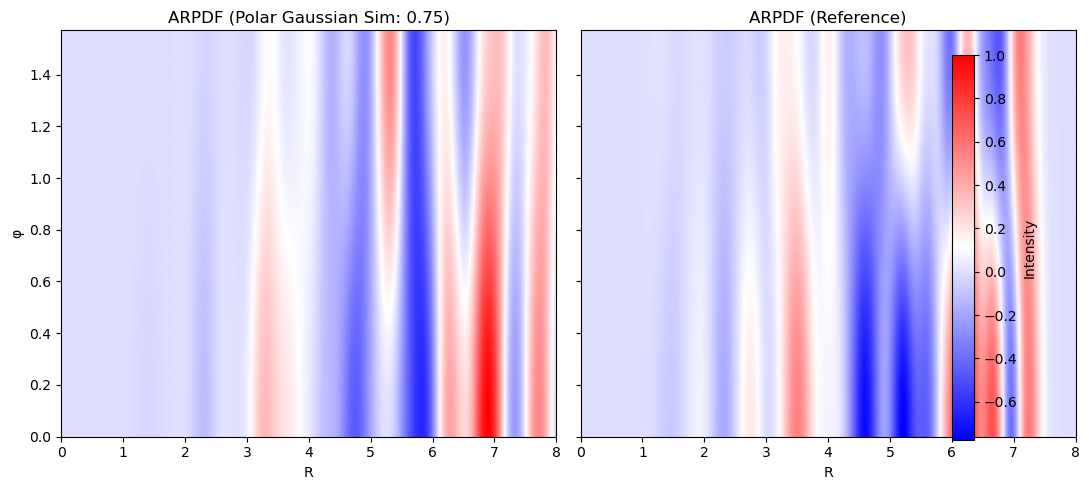

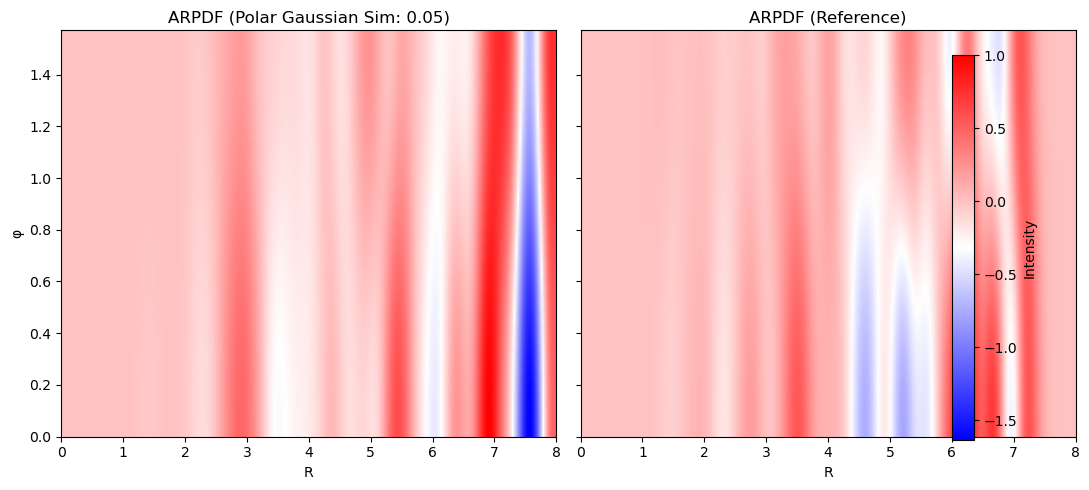

In [4]:
polar_workflow_demo(
    R=R,
    Theta=phi,
    ARPDF_ref=ARPDF_ref,
    exp_name="polar_test",
    sigma_similarity=0.3,
    sigma0=0.2,
    cutoff=10.0,
    weight_cutoff=5.0,
    metric='angular_scale',
    stretch_distances=[round(1.0 + 0.1 * i, 1) for i in range(5)],
    neg=False
)

In [ ]:
4.62/1.008/(15.74/54.94)

In [ ]:
u0 = mda.Universe('data/CCl4/CCl4.gro')
dir_name = "exp1"
device = torch.device('cuda')
ARPDF_optimizer = ARPDFOptimizer(
    X, Y, ARPDF_ref, Counter(u0.atoms.types), filter_fourier, cutoff=10.0, sigma0=sigma0, weight_cutoff=8.0,
    lr=0.01, gamma=0.995, f_lb=-0.9, s=0.0, beta=0.0, epochs=500, device=device
)
u1, u2, modified_atoms, polar_axis = utils.load_structure_data(f'tmp/{dir_name}')
modified_atoms = select_nbr_mols(u1, modified_atoms, nbr_distance=None, periodic=True)
ARPDF_optimizer.set_system(out_dir=f'tmp/{dir_name}', u1=u1, u2=u2, modified_atoms=modified_atoms, polar_axis=polar_axis)
print(modified_atoms)

In [ ]:
ARPDF_optimizer.optimize()

In [ ]:
df = pd.read_csv(f"tmp/{dir_name}/log.txt")
epochs = df['epoch'].values
loss = df['loss'].values
cos_sim = df['cos_sim'].values
line1, = plt.plot(epochs, loss, label='Loss')
plt.xlabel('Epoch')
plt.twinx()
line2, = plt.plot(epochs, cos_sim, label='Cosine Similarity', color='red')
plt.ylabel('Cosine Similarity')
plt.legend([line1, line2], ['Loss', 'Cosine Similarity'], loc='upper right')
plt.title('Optimization Progress')
plt.show()

In [ ]:
u1, u2, modified_atoms, polar_axis = utils.load_structure_data(f'tmp/{dir_name}')
polar_axis = np.array(polar_axis)
polar_axis /= np.linalg.norm(polar_axis)
# u2 = mda.Universe('tmp/cos_sim/CCl4_best_init.gro')
trajs = np.load(f"tmp/{dir_name}/traj.npy")[::5]

def rotation_matrix(v1, v2):
    u = v1 - v2
    if np.linalg.norm(u) < 1e-8:
        return np.eye(3)
    u /= np.linalg.norm(u)
    return np.eye(3) - 2 * np.outer(u, u)

R = rotation_matrix(polar_axis, np.array([0., 0., 1.]))
center_group = u2.atoms[modified_atoms]
_center = center_group[0].position[None, :]
around_group = u2.select_atoms("around 6.0 group center", center = center_group, periodic=True)
center_group.positions = utils.box_shift(center_group.positions - _center, u2.dimensions) @ R.T
around_group.positions = utils.box_shift(around_group.positions - _center, u2.dimensions) @ R.T
trajs = utils.box_shift(trajs - _center[None, :, :], u2.dimensions) @ R.T
full_trajs = np.zeros((trajs.shape[0], center_group.n_atoms + around_group.n_atoms, 3))
full_trajs[:, :center_group.n_atoms, :] = trajs
full_trajs[:, center_group.n_atoms:, :] = around_group.positions[None, :, :]
u_new = mda.Merge(center_group, around_group)
u_new.load_new(full_trajs[1:], format="memory", dt=1.0)
# print(around_group.positions[:5])
with mda.Writer(f"tmp/{dir_name}/traj.xyz", center_group.n_atoms + around_group.n_atoms) as W:
    for ts in u_new.trajectory:
        W.write(u_new.atoms)